In [1]:
import findspark
findspark.init()
import pyspark
sc = pyspark.SparkContext()

In [2]:
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.regression import LabeledPoint

from string import split,strip

from pyspark.mllib.tree import GradientBoostedTrees, GradientBoostedTreesModel, RandomForest, RandomForestModel
from pyspark.mllib.util import MLUtils

### Cover Type

Classify geographical locations according to their predicted tree cover:

* **URL:** http://archive.ics.uci.edu/ml/datasets/Covertype
* **Abstract:** Forest CoverType dataset
* **Data Set Description:** http://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.info

In [3]:
#define a dictionary of cover types
CoverTypes={1.0: 'Spruce/Fir',
            2.0: 'Lodgepole Pine',
            3.0: 'Ponderosa Pine',
            4.0: 'Cottonwood/Willow',
            5.0: 'Aspen',
            6.0: 'Douglas-fir',
            7.0: 'Krummholz' }
print 'Tree Cover Types:'
CoverTypes

Tree Cover Types:


{1.0: 'Spruce/Fir',
 2.0: 'Lodgepole Pine',
 3.0: 'Ponderosa Pine',
 4.0: 'Cottonwood/Willow',
 5.0: 'Aspen',
 6.0: 'Douglas-fir',
 7.0: 'Krummholz'}

In [4]:
# creating a directory called covtype, download and decompress covtype.data.gz into it

from os.path import exists
if not exists('covtype'):
    print "creating directory covtype"
    !mkdir covtype
%cd covtype
if not exists('covtype.data'):
    if not exists('covtype.data.gz'):
        print 'downloading covtype.data.gz'
        !curl -O http://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz
    print 'decompressing covtype.data.gz'
    !gunzip -f covtype.data.gz
!ls -l
%cd ..

/Users/alexegg/Development/DSE/DSE230/hmwk5/covtype
total 146816
-rw-r--r--  1 alexegg  staff  75169317 May 17 19:27 covtype.data
/Users/alexegg/Development/DSE/DSE230/hmwk5


In [5]:
# Define the feature names
cols_txt="""
Elevation, Aspect, Slope, Horizontal_Distance_To_Hydrology,
Vertical_Distance_To_Hydrology, Horizontal_Distance_To_Roadways,
Hillshade_9am, Hillshade_Noon, Hillshade_3pm,
Horizontal_Distance_To_Fire_Points, Wilderness_Area (4 binarycolumns), 
Soil_Type (40 binary columns), Cover_Type
"""

In [6]:
# Break up features that are made out of several binary features.
from string import split,strip
cols=[strip(a) for a in split(cols_txt,',')]
colDict={a:[a] for a in cols}
colDict['Soil_Type (40 binary columns)'] = ['ST_'+str(i) for i in range(40)]
colDict['Wilderness_Area (4 binarycolumns)'] = ['WA_'+str(i) for i in range(4)]
Columns=[]
for item in cols:
    Columns=Columns+colDict[item]
print Columns

['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'WA_0', 'WA_1', 'WA_2', 'WA_3', 'ST_0', 'ST_1', 'ST_2', 'ST_3', 'ST_4', 'ST_5', 'ST_6', 'ST_7', 'ST_8', 'ST_9', 'ST_10', 'ST_11', 'ST_12', 'ST_13', 'ST_14', 'ST_15', 'ST_16', 'ST_17', 'ST_18', 'ST_19', 'ST_20', 'ST_21', 'ST_22', 'ST_23', 'ST_24', 'ST_25', 'ST_26', 'ST_27', 'ST_28', 'ST_29', 'ST_30', 'ST_31', 'ST_32', 'ST_33', 'ST_34', 'ST_35', 'ST_36', 'ST_37', 'ST_38', 'ST_39', 'Cover_Type']


In [7]:
# Have a look at the first two lines of the data file
!head -2 covtype/covtype.data

2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5


In [8]:
# Read the file into an RDD
# If doing this on a real cluster, you need the file to be available on all nodes, ideally in HDFS.
path='covtype/covtype.data'
inputRDD=sc.textFile(path)

In [9]:
# Transform the text RDD into an RDD of LabeledPoints
Data=inputRDD.map(lambda line: [float(strip(x)) for x in line.split(',')])\
     .map(lambda a: LabeledPoint(a[-1], a[0:-1]))

[LabeledPoint(5.0, [2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
 LabeledPoint(5.0, [2590.0,56.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
 LabeledPoint(2.0, [2804.0,139.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0])]

In [11]:
# count the number of examples of each type
total=Data.cache().count()
print 'total data size=',total
counts=Data.map(lambda sample: (sample.label, 1)).reduceByKey(lambda x,y: x+y).collect()

counts.sort(key=lambda x:x[1], reverse=True)
print '              type (label):   percent of total'
print '---------------------------------------------------------'
print '\n'.join(['%20s (%3.1f):\t%4.2f'%(CoverTypes[a[0]],a[0],100.0*a[1]/float(total)) for a in counts])

total data size= 581012
              type (label):   percent of total
---------------------------------------------------------
      Lodgepole Pine (2.0):	48.76
          Spruce/Fir (1.0):	36.46
      Ponderosa Pine (3.0):	6.15
           Krummholz (7.0):	3.53
         Douglas-fir (6.0):	2.99
               Aspen (5.0):	1.63
   Cottonwood/Willow (4.0):	0.47


```
total data size= 581012
              type (label):   percent of total
---------------------------------------------------------
      Lodgepole Pine (2.0):	48.76
          Spruce/Fir (1.0):	36.46
      Ponderosa Pine (3.0):	6.15
           Krummholz (7.0):	3.53
         Douglas-fir (6.0):	2.99
               Aspen (5.0):	1.63
   Cottonwood/Willow (4.0):	0.47
```

### Making the problem binary

The implementation of BoostedGradientTrees in MLLib supports only binary problems. the `CovTYpe` problem has
7 classes. To make the problem binary we choose the `Lodgepole Pine` (label = 2.0). We therefor transform the dataset to a new dataset where the label is `1.0` is the class is `Lodgepole Pine` and is `0.0` otherwise.

In [12]:
Label=2.0
mapping = {Label: 1.0}
Data=inputRDD.map(lambda line: [float(x) for x in line.split(',')])\
    .map(lambda a: LabeledPoint(mapping.setdefault(a[-1], 0.0), a[0:-1]))

[LabeledPoint(0.0, [2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
 LabeledPoint(0.0, [2590.0,56.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
 LabeledPoint(1.0, [2804.0,139.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0])]

### Reducing data size
In order to see the effects of overfitting more clearly, we reduce the size of the data by a factor of 10

In [13]:
Data1=Data.sample(False,0.1).cache()
(trainingData,testData)=Data1.randomSplit([0.7,0.3])

print 'Sizes: Data1=%d, trainingData=%d, testData=%d'%(Data1.count(),trainingData.cache().count(),testData.cache().count())

Sizes: Data1=57953, trainingData=40571, testData=17382


In [14]:
counts=testData.map(lambda lp:(lp.label,1)).reduceByKey(lambda x,y:x+y).collect()
counts.sort(key=lambda x:x[1],reverse=True)
counts

[(0.0, 8776), (1.0, 8606)]

### Gradient Boosted Trees

* Following [this example](http://spark.apache.org/docs/latest/mllib-ensembles.html#gradient-boosted-trees-gbts) from the mllib documentation

* [pyspark.mllib.tree.GradientBoostedTrees documentation](http://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.tree.GradientBoostedTrees)

#### Main classes and methods

* `GradientBoostedTrees` is the class that implements the learning trainClassifier,
   * It's main method is `trainClassifier(trainingData)` which takes as input a training set and generates an instance of `GradientBoostedTreesModel`
   * The main parameter from train Classifier are:
      * **data** – Training dataset: RDD of LabeledPoint. Labels should take values {0, 1}.
      * categoricalFeaturesInfo – Map storing arity of categorical features. E.g., an entry (n -> k) indicates that feature n is categorical with k categories indexed from 0: {0, 1, ..., k-1}.
      * **loss** – Loss function used for minimization during gradient boosting. Supported: {“logLoss” (default), “leastSquaresError”, “leastAbsoluteError”}.
      * **numIterations** – Number of iterations of boosting. (default: 100)
      * **learningRate** – Learning rate for shrinking the contribution of each estimator. The learning rate should be between in the interval (0, 1]. (default: 0.1)
      * **maxDepth** – Maximum depth of the tree. E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. (default: 3)
      * **maxBins** – maximum number of bins used for splitting features (default: 32) DecisionTree requires maxBins >= max categories
      
      
* `GradientBoostedTreesModel` represents the output of the boosting process: a linear combination of classification trees. The methods supported by this class are:
   * `save(sc, path)` : save the tree to a given filename, sc is the Spark Context.
   * `load(sc,path)` : The counterpart to save - load classifier from file.
   * `predict(X)` : predict on a single datapoint (the `.features` field of a `LabeledPont`) or an RDD of datapoints.
   * `toDebugString()` : print the classifier in a human readable format.

In [ ]:
from time import time
errors={}
for depth in [1,3,6,10]:
    start=time()
    catInfo = {}
    for i in range(10,54):
        catInfo[i] = 2
    model=GradientBoostedTrees.trainClassifier(trainingData, categoricalFeaturesInfo={}, 
                                               numIterations=10, maxDepth=depth, learningRate=0.25,
                                              maxBins=54)
    errors[depth]={}
    dataSets={'train':trainingData,'test':testData}
    for name in dataSets.keys():  # Calculate errors on train and test sets
        data=dataSets[name]
        Predicted=model.predict(data.map(lambda x: x.features))

        LabelsAndPredictions = data.map(lambda lp: lp.label).zip(Predicted)
        Err = LabelsAndPredictions.filter(lambda (v,p): v != p).count()/float(data.count())
        errors[depth][name]=Err
    print depth,errors[depth],int(time()-start),'seconds'
print errors

#.167, .148

1 {'test': 0.27206305373374756, 'train': 0.2666436617288211} 9 seconds
3 {'test': 0.23271200092049246, 'train': 0.2265657735821153} 10 seconds
6 {'test': 0.19819353354044414, 'train': 0.18417095955238963} 13 seconds
10 {'test': 0.14693360948107237, 'train': 0.09321929457001306} 20 seconds
{1: {'test': 0.27206305373374756, 'train': 0.2666436617288211}, 10: {'test': 0.14693360948107237, 'train': 0.09321929457001306}, 3: {'test': 0.23271200092049246, 'train': 0.2265657735821153}, 6: {'test': 0.19819353354044414, 'train': 0.18417095955238963}}


In [16]:
B10 = errors

Populating the interactive namespace from numpy and matplotlib
0


`%matplotlib` prevents importing * from pylab and numpy


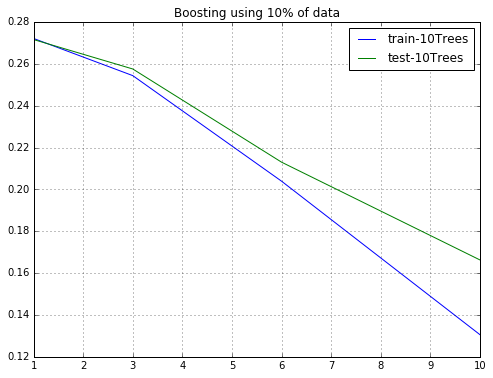

In [17]:
# Plot Train/test accuracy vs Depth of trees graph
%pylab inline
from plot_utils import *
make_figure([B10],['10Trees'],Title='Boosting using 10% of data')

### Random Forests

* Following [this example](http://spark.apache.org/docs/latest/mllib-ensembles.html#classification) from the mllib documentation

* [pyspark.mllib.trees.RandomForest documentation](http://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.tree.RandomForest)

**trainClassifier**`(data, numClasses, categoricalFeaturesInfo, numTrees, featureSubsetStrategy='auto', impurity='gini', maxDepth=4, maxBins=32, seed=None)`   
Method to train a decision tree model for binary or multiclass classification.

**Parameters:**  
* *data* – Training dataset: RDD of LabeledPoint. Labels should take values {0, 1, ..., numClasses-1}.  
* *numClasses* – number of classes for classification.  
* *categoricalFeaturesInfo* – Map storing arity of categorical features. E.g., an entry (n -> k) indicates that feature n is categorical with k categories indexed from 0: {0, 1, ..., k-1}.  
* *numTrees* – Number of trees in the random forest.  
* *featureSubsetStrategy* – Number of features to consider for splits at each node. Supported: “auto” (default), “all”, “sqrt”, “log2”, “onethird”. If “auto” is set, this parameter is set based on numTrees: if numTrees == 1, set to “all”; if numTrees > 1 (forest) set to “sqrt”.
* *impurity* – Criterion used for information gain calculation. Supported values: “gini” (recommended) or “entropy”.  
* *maxDepth* – Maximum depth of the tree. E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. (default: 4)  
* *maxBins* – maximum number of bins used for splitting features (default: 32)
* *seed* – Random seed for bootstrapping and choosing feature subsets.  

**Returns:**	
RandomForestModel that can be used for prediction

In [18]:
from time import time
errors={}
for depth in [1,3,6,10,15,20]:
    start=time()
    model = RandomForest.trainClassifier(trainingData, numClasses=2, categoricalFeaturesInfo={},
                                     numTrees=10, featureSubsetStrategy="auto",
                                     impurity='gini', maxDepth=depth)
    #print model.toDebugString()
    errors[depth]={}
    dataSets={'train':trainingData,'test':testData}
    for name in dataSets.keys():  # Calculate errors on train and test sets
        data=dataSets[name]
        Predicted=model.predict(data.map(lambda x: x.features))

        LabelsAndPredictions = data.map(lambda lp: lp.label).zip(Predicted)
        Err = LabelsAndPredictions.filter(lambda (v,p): v != p).count()/float(data.count())
        errors[depth][name]=Err
    print depth,errors[depth],int(time()-start),'seconds'
print errors

1 {'test': 0.48048444495465503, 'train': 0.4723873840808437} 2 seconds
3 {'test': 0.2960624497761451, 'train': 0.29680197704861877} 2 seconds
6 {'test': 0.25789232005510276, 'train': 0.2573588783674668} 2 seconds
10 {'test': 0.2266674319825508, 'train': 0.22256478015121486} 3 seconds
15 {'test': 0.20135460911491218, 'train': 0.17578115442022071} 5 seconds
20 {'test': 0.1825852370565951, 'train': 0.14637010937385303} 7 seconds
{1: {'test': 0.48048444495465503, 'train': 0.4723873840808437}, 3: {'test': 0.2960624497761451, 'train': 0.29680197704861877}, 6: {'test': 0.25789232005510276, 'train': 0.2573588783674668}, 10: {'test': 0.2266674319825508, 'train': 0.22256478015121486}, 15: {'test': 0.20135460911491218, 'train': 0.17578115442022071}, 20: {'test': 0.1825852370565951, 'train': 0.14637010937385303}}


0


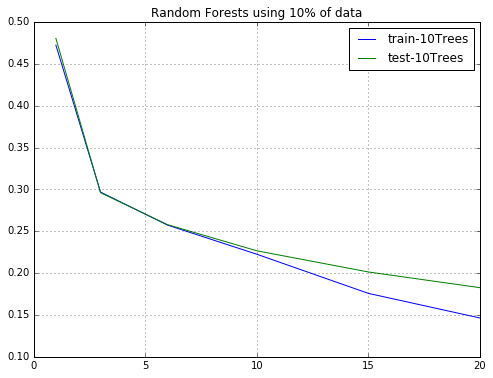

In [19]:
RF_10trees = errors
# Plot Train/test accuracy vs Depth of trees graph
make_figure([RF_10trees],['10Trees'],Title='Random Forests using 10% of data')

### Now plot B10 and RF_10trees performance curves in the same graph

0
1


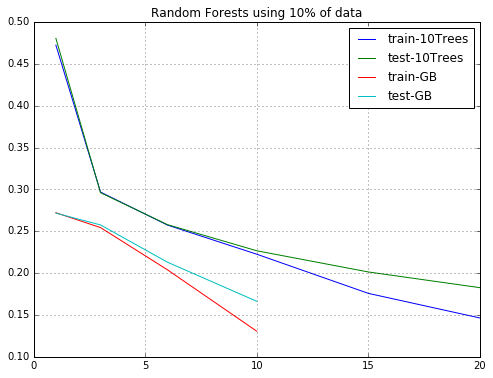

In [20]:
make_figure([RF_10trees, B10],['10Trees', 'GB'],Title='GBT vs RF')